<a href="https://colab.research.google.com/github/secret-coder-pro/major-project-expected_ctc/blob/main/epected_ctc%20using%20random%20forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('expected_ctc.csv')
df.head()

,IDX,Applicant_ID,Total_Experience,Total_Experience_in_field_applied,Department,Role,Industry,Organization,Designation,Education,...,Curent_Location,Preferred_location,Current_CTC,Inhand_Offer,Last_Appraisal_Rating,No_Of_Companies_worked,Number_of_Publications,Certifications,International_degree_any,Expected_CTC
0,1,22753,0,0,NaN,NaN,NaN,NaN,NaN,PG,...,Guwahati,Pune,0,N,NaN,0,0,0,0,384551
1,2,51087,23,14,HR,Consultant,Analytics,H,HR,Doctorate,...,Bangalore,Nagpur,2702664,Y,Key_Performer,2,4,0,0,3783729
2,3,38413,21,12,Top Management,Consultant,Training,J,NaN,Doctorate,...,Ahmedabad,Jaipur,2236661,Y,Key_Performer,5,3,0,0,3131325
3,4,11501,15,8,Banking,Financial Analyst,Aviation,F,HR,Doctorate,...,Kanpur,Kolkata,2100510,N,C,5,3,0,0,2608833
4,5,58941,10,5,Sales,Project Manager,Insurance,E,Medical Officer,Grad,...,Ahmedabad,Ahmedabad,1931644,N,C,2,3,0,0,2221390


In [196]:
# Initial Data Preprocessing
# Drop unnecessary columns
df = df.drop(['IDX', 'Applicant_ID'], axis=1)
print("Dataset shape after dropping ID columns:", df.shape)

Dataset shape after dropping ID columns: (25000, 27)


In [197]:
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [198]:
original_education = df['Education'].copy()

df.head()

,Total_Experience,Total_Experience_in_field_applied,Department,Role,Industry,Organization,Designation,Education,Graduation_Specialization,University_Grad,...,Curent_Location,Preferred_location,Current_CTC,Inhand_Offer,Last_Appraisal_Rating,No_Of_Companies_worked,Number_of_Publications,Certifications,International_degree_any,Expected_CTC
0,0,0,NaN,NaN,NaN,NaN,NaN,PG,Arts,Lucknow,...,Guwahati,Pune,0,N,NaN,0,0,0,0,384551
1,23,14,HR,Consultant,Analytics,H,HR,Doctorate,Chemistry,Surat,...,Bangalore,Nagpur,2702664,Y,Key_Performer,2,4,0,0,3783729
2,21,12,Top Management,Consultant,Training,J,NaN,Doctorate,Zoology,Jaipur,...,Ahmedabad,Jaipur,2236661,Y,Key_Performer,5,3,0,0,3131325
3,15,8,Banking,Financial Analyst,Aviation,F,HR,Doctorate,Others,Bangalore,...,Kanpur,Kolkata,2100510,N,C,5,3,0,0,2608833
4,10,5,Sales,Project Manager,Insurance,E,Medical Officer,Grad,Zoology,Mumbai,...,Ahmedabad,Ahmedabad,1931644,N,C,2,3,0,0,2221390


In [199]:
# education levels and details about phd, pg ug grad are inconsistent
#changeng education level to the amount of detail provided in other detail
phd_cols = ['Passing_Year_Of_PHD', 'University_PHD', 'PHD_Specialization']
pg_cols = ['Passing_Year_Of_PG', 'University_PG', 'PG_Specialization']
grad_cols = ['Passing_Year_Of_Graduation', 'University_Grad', 'Graduation_Specialization']

condition1 = df[phd_cols + pg_cols + grad_cols].notnull().all(axis=1)
condition2 = (
    df[pg_cols + grad_cols].notnull().all(axis=1) &
    df[phd_cols].isnull().all(axis=1)
)
condition3 = (
    df[grad_cols].notnull().all(axis=1) &
    df[phd_cols + pg_cols].isnull().all(axis=1)
)

df.loc[condition3, 'Education'] = 'Grad'
df.loc[condition2, 'Education'] = 'PG'
df.loc[condition1, 'Education'] = 'Doctorate'

num_changes = (df['Education'] != original_education).sum()
print(f"Number of education changes made: {num_changes}")

print("\nEducation distribution:")
print(df['Education'].value_counts())


Number of education changes made: 12555

Education distribution:
Education
Doctorate     13119
Under Grad     6180
PG             4189
Grad           1512
Name: count, dtype: int64


In [200]:
# Encode Categorical Variables

df['Education'] = df['Education'].replace({'Doctorate': 4, 'PG': 3, 'Grad': 2, 'Under Grad': 1})
df['Education'] = df['Education'].astype(int)

df['Inhand_Offer'] = df['Inhand_Offer'].replace({'Y': 1, 'N': 0})
df['Inhand_Offer'] = df['Inhand_Offer'].astype(int)

df['Last_Appraisal_Rating'] = df['Last_Appraisal_Rating'].fillna(0)
df['Last_Appraisal_Rating'] = df['Last_Appraisal_Rating'].replace({
    'Key_Performer': 5, 'A': 4, 'B': 3, 'C': 2, 'D': 1, '': 0
})
df['Last_Appraisal_Rating'] = df['Last_Appraisal_Rating'].astype(int)

print("Education unique values:", sorted(df['Education'].unique()))
print("Inhand_Offer unique values:", sorted(df['Inhand_Offer'].unique()))
print("Last_Appraisal_Rating unique values:", sorted(df['Last_Appraisal_Rating'].unique()))


Education unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Inhand_Offer unique values: [np.int64(0), np.int64(1)]
Last_Appraisal_Rating unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [201]:
cat = [col for col in df.columns if df[col].dtype == 'object']
num = [col for col in df.columns if df[col].dtype != 'object']

print(f"Categorical columns ({len(cat)}): {cat}")
print(f"Numerical columns ({len(num)}): {len(num)}")



df.head()

Categorical columns (13): ['Department', 'Role', 'Industry', 'Organization', 'Designation', 'Graduation_Specialization', 'University_Grad', 'PG_Specialization', 'University_PG', 'PHD_Specialization', 'University_PHD', 'Curent_Location', 'Preferred_location']
Numerical columns (14): 14


,Total_Experience,Total_Experience_in_field_applied,Department,Role,Industry,Organization,Designation,Education,Graduation_Specialization,University_Grad,...,Curent_Location,Preferred_location,Current_CTC,Inhand_Offer,Last_Appraisal_Rating,No_Of_Companies_worked,Number_of_Publications,Certifications,International_degree_any,Expected_CTC
0,0,0,NaN,NaN,NaN,NaN,NaN,2,Arts,Lucknow,...,Guwahati,Pune,0,0,0,0,0,0,0,384551
1,23,14,HR,Consultant,Analytics,H,HR,4,Chemistry,Surat,...,Bangalore,Nagpur,2702664,1,5,2,4,0,0,3783729
2,21,12,Top Management,Consultant,Training,J,NaN,4,Zoology,Jaipur,...,Ahmedabad,Jaipur,2236661,1,5,5,3,0,0,3131325
3,15,8,Banking,Financial Analyst,Aviation,F,HR,4,Others,Bangalore,...,Kanpur,Kolkata,2100510,0,2,5,3,0,0,2608833
4,10,5,Sales,Project Manager,Insurance,E,Medical Officer,4,Zoology,Mumbai,...,Ahmedabad,Ahmedabad,1931644,0,2,2,3,0,0,2221390


In [202]:
df[cat].isnull().sum()

,0
Department,2778
Role,963
Industry,908
Organization,908
Designation,3129
Graduation_Specialization,6180
University_Grad,6180
PG_Specialization,7692
University_PG,7692
PHD_Specialization,11881


In [203]:
for col in cat:
  print(f'Unique labels in {col}: {len(df[col].unique())}')

Unique labels in Department: 13
Unique labels in Role: 25
Unique labels in Industry: 12
Unique labels in Organization: 17
Unique labels in Designation: 19
Unique labels in Graduation_Specialization: 12
Unique labels in University_Grad: 14
Unique labels in PG_Specialization: 12
Unique labels in University_PG: 14
Unique labels in PHD_Specialization: 12
Unique labels in University_PHD: 14
Unique labels in Curent_Location: 15
Unique labels in Preferred_location: 15


In [204]:
df[cat].head()

,Department,Role,Industry,Organization,Designation,Graduation_Specialization,University_Grad,PG_Specialization,University_PG,PHD_Specialization,University_PHD,Curent_Location,Preferred_location
0,NaN,NaN,NaN,NaN,NaN,Arts,Lucknow,NaN,NaN,NaN,NaN,Guwahati,Pune
1,HR,Consultant,Analytics,H,HR,Chemistry,Surat,Others,Surat,Chemistry,Mangalore,Bangalore,Nagpur
2,Top Management,Consultant,Training,J,NaN,Zoology,Jaipur,Zoology,Jaipur,Zoology,Lucknow,Ahmedabad,Jaipur
3,Banking,Financial Analyst,Aviation,F,HR,Others,Bangalore,Zoology,Bangalore,Chemistry,Guwahati,Kanpur,Kolkata
4,Sales,Project Manager,Insurance,E,Medical Officer,Zoology,Mumbai,Zoology,Mumbai,Zoology,Bangalore,Ahmedabad,Ahmedabad


In [205]:
df = pd.get_dummies(df, columns=cat, drop_first=True, dtype=int)
print(f"Dataset shape after encoding: {df.shape}")

Dataset shape after encoding: (25000, 184)


In [206]:
df.head()

,Total_Experience,Total_Experience_in_field_applied,Education,Passing_Year_Of_Graduation,Passing_Year_Of_PG,Passing_Year_Of_PHD,Current_CTC,Inhand_Offer,Last_Appraisal_Rating,No_Of_Companies_worked,...,Preferred_location_Guwahati,Preferred_location_Jaipur,Preferred_location_Kanpur,Preferred_location_Kolkata,Preferred_location_Lucknow,Preferred_location_Mangalore,Preferred_location_Mumbai,Preferred_location_Nagpur,Preferred_location_Pune,Preferred_location_Surat
0,0,0,2,2020.0,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,23,14,4,1988.0,1990.0,1997.0,2702664,1,5,2,...,0,0,0,0,0,0,0,1,0,0
2,21,12,4,1990.0,1992.0,1999.0,2236661,1,5,5,...,0,1,0,0,0,0,0,0,0,0
3,15,8,4,1997.0,1999.0,2005.0,2100510,0,2,5,...,0,0,0,1,0,0,0,0,0,0
4,10,5,4,2004.0,2006.0,2010.0,1931644,0,2,2,...,0,0,0,0,0,0,0,0,0,0


In [207]:
nullcol=[var for var in df.columns if df[var].isnull().sum()!=0]
nullcol

['Passing_Year_Of_Graduation', 'Passing_Year_Of_PG', 'Passing_Year_Of_PHD']

In [208]:
df[nullcol].isnull().sum()

,0
Passing_Year_Of_Graduation,6180
Passing_Year_Of_PG,7692
Passing_Year_Of_PHD,11881


In [209]:
unexpected_grad_missing = (
    df['Education'].isin(['Grad', 'PG', 'Doctorate']) & df['Passing_Year_Of_Graduation'].isnull()
)

unexpected_pg_missing = (
    df['Education'].isin(['PG', 'Doctorate']) & df['Passing_Year_Of_PG'].isnull()
)

unexpected_phd_missing = (
    (df['Education'] == 'Doctorate') & df['Passing_Year_Of_PHD'].isnull()
)

unexpected_missing = unexpected_grad_missing | unexpected_pg_missing | unexpected_phd_missing

num_unexpected_missing = unexpected_missing.sum()
print("Number of unexpected missing values:", num_unexpected_missing)

print(df[unexpected_missing])

Number of unexpected missing values: 0
Empty DataFrame
Columns: [Total_Experience, Total_Experience_in_field_applied, Education, Passing_Year_Of_Graduation, Passing_Year_Of_PG, Passing_Year_Of_PHD, Current_CTC, Inhand_Offer, Last_Appraisal_Rating, No_Of_Companies_worked, Number_of_Publications, Certifications, International_degree_any, Expected_CTC, Department_Analytics/BI, Department_Banking, Department_Education, Department_Engineering, Department_HR, Department_Healthcare, Department_IT-Software, Department_Marketing, Department_Others, Department_Sales, Department_Top Management, Role_Area Sales Manager, Role_Associate, Role_Bio statistician, Role_Business Analyst, Role_CEO, Role_Consultant, Role_Data scientist, Role_Financial Analyst, Role_Head, Role_Lab Executuve, Role_Others, Role_Principal Analyst, Role_Professor, Role_Project Manager, Role_Research Scientist, Role_Researcher, Role_Sales Execituve, Role_Sales Manager, Role_Scientist, Role_Senior Analyst, Role_Senior Researcher,

In [210]:

print("Missing values before filling: ")
for col in nullcol:
    print(f"{col}: {df[col].isnull().sum()}")

df[nullcol] = df[nullcol].fillna(0)

df['Not_Graduated'] = (df['Passing_Year_Of_Graduation'] == 0).astype(int)
df['Not_PG'] = (df['Passing_Year_Of_PG'] == 0).astype(int)
df['Not_PHD'] = (df['Passing_Year_Of_PHD'] == 0).astype(int)

print("Missing values after filling: ")
for col in nullcol:
    print(f"{col}: {df[col].isnull().sum()}")

df.shape

Missing values before filling: 
Passing_Year_Of_Graduation: 6180
Passing_Year_Of_PG: 7692
Passing_Year_Of_PHD: 11881
Missing values after filling: 
Passing_Year_Of_Graduation: 0
Passing_Year_Of_PG: 0
Passing_Year_Of_PHD: 0


(25000, 187)

In [211]:
#OUTLIERS
columns_with_outliers = []
for col in df.columns:
    unique_vals = set(df[col].unique())

    if unique_vals <= {0, 1}:
        continue

    # Finding outliers
    Q1, Q3 = np.percentile(df[col], [25, 75])
    IQR = Q3 - Q1
    outliers = df[col][(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

    if len(set(outliers) - {0, 1}) > 0:
        columns_with_outliers.append(col)

print(f"Columns with outliers: {columns_with_outliers}")


Columns with outliers: ['Total_Experience_in_field_applied', 'Certifications']


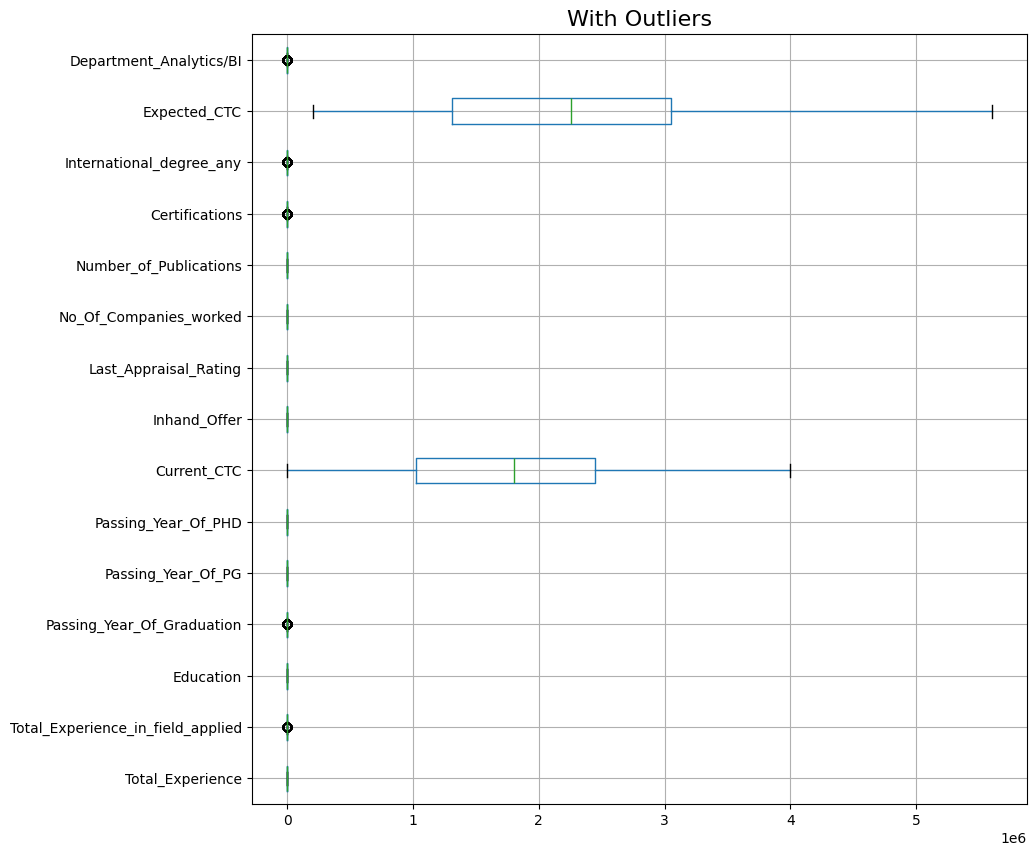

In [212]:
cont=df.dtypes[(df.dtypes!='uint8') & (df.dtypes!='bool')].index
plt.figure(figsize=(10,10))
df[cont].iloc[:, :15].boxplot(vert=False)
plt.title('With Outliers',fontsize=16)
plt.show()

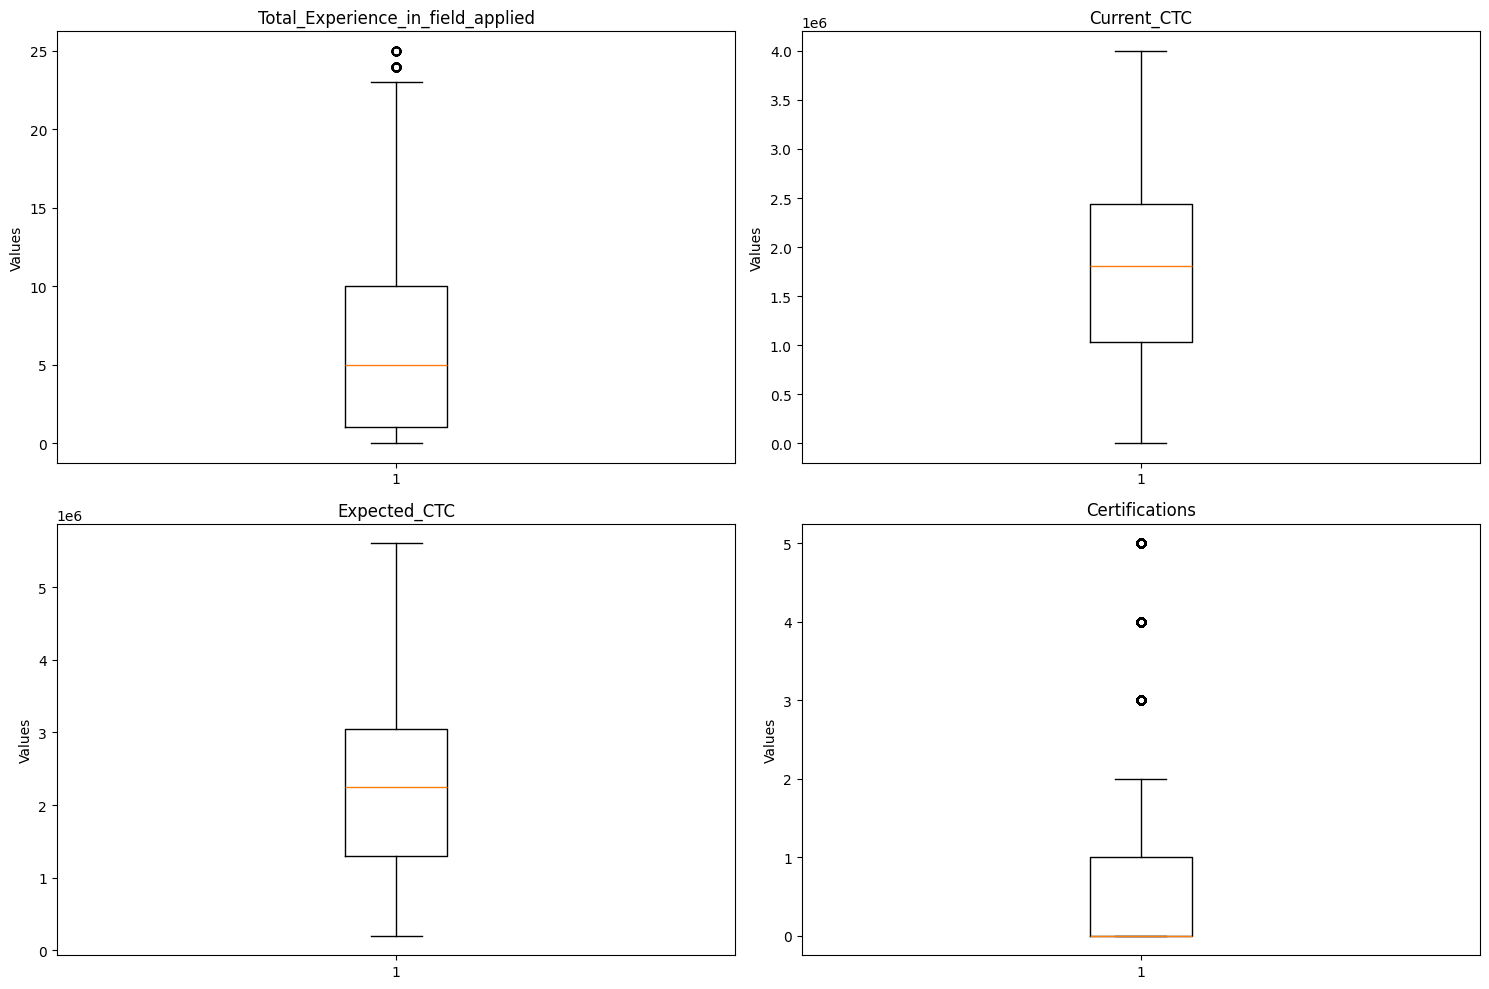

In [213]:

plt.figure(figsize=(15, 10))
important_cols = ['Total_Experience_in_field_applied', 'Current_CTC', 'Expected_CTC', 'Certifications']
for i, col in enumerate(important_cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df[col])
    plt.title(f'{col}')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [214]:
from sklearn.model_selection import train_test_split

X = df.drop('Expected_CTC', axis=1)
y = df['Expected_CTC']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Feature matrix shape: (25000, 186)
Target vector shape: (25000,)


In [215]:
for col in columns_with_outliers:
    Q1, Q3 = np.percentile(X_train[col], [25, 75])
    IQR = Q3 - Q1
    lr = Q1 - 1.5 * IQR  # lower range
    ur = Q3 + 1.5 * IQR  # upper range

    outliers_before = ((X_train[col] < lr) | (X_train[col] > ur)).sum()

    X_train[col] = np.where(X_train[col] > ur, ur, X_train[col])
    X_train[col] = np.where(X_train[col] < lr, lr, X_train[col])

    print(f"{col}: {outliers_before} outliers capped")

Total_Experience_in_field_applied: 95 outliers capped
Certifications: 2369 outliers capped


In [216]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_jobs=-1, random_state=42)

In [217]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Training metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training Metrics:")
print(f"R² Score: {train_r2:.6f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE: {train_mae:.2f}")

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"R² Score: {test_r2:.6f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")


Training Metrics:
R² Score: 0.997569
RMSE: 57185.96
MAE: 36580.07

Testing Metrics:
R² Score: 0.996491
RMSE: 68887.38
MAE: 44448.49
